# Réseau de neurones: les bases en numpy


Le but de ce TP est d'acquérir les bases nécessaires à la compréhension des réseaux de neurones à partir d'un modèle simple de type Softmax. La tâche d'apprentissage consiste à classifier les images (28 par 28 pixels) de la base MNIST (http://yann.lecun.com/exdb/mnist/) en 10 catégories représentant les chiffres 0-9.

## Chargement des données

### Téléchargement de la base de données

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt

mnistfile="mnist.pkl.gz"

# If you need to download it : 
if("mnist.pkl.gz" not in os.listdir(".")):
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

### Chargement de la base en mémoire et séparation des jeux de données

In [2]:
import dataset_loader
train_set, valid_set, test_set = dataset_loader.load_mnist(mnistfile)

### Visualisation d'un échantillon

label: 7


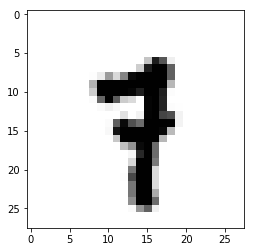

In [3]:
img_id = 900
plt.imshow(train_set[0][img_id].reshape(28,28),cmap='Greys')
print("label: {}".format(train_set[1][img_id]))

### Dimensions des jeux de données

In [4]:
def getDimDataset(train_set):
    n_training = train_set[0].shape[0]
    n_feature = train_set[0].shape[1]
    n_label = len(np.unique(train_set[1]))
    return n_training, n_feature, n_label

In [5]:
print("Train set dims : {}".format(getDimDataset(train_set)))
print("Valid set dims : {}".format(getDimDataset(valid_set)))
print("Test set dims  : {}".format(getDimDataset(test_set)))

Train set dims : (50000, 784, 10)
Valid set dims : (10000, 784, 10)
Test set dims  : (10000, 784, 10)


## Algorithme d'apprentissage 

Pour plus de clarté, les fonctions développées au cours du TP1 et 2 ont été encapsulées dans une classe NNet (définie dans le fichier NNet.py) permettant de gérer automatiquement les calculs de propagation au travers du réseau. On peut ainsi facilement modifier la configuration du réseau (nombre de couches, taille des couches, etc.).

In [6]:
from NNet import NNet

# description des couches cachees
#hidden_layers = []
#hidden_layers = [{'n_neurons': 70, 'activation': 'sigmoid'}]
# hidden_layers = [{'n_neurons': 70, 'activation': 'sigmoid'},
#                  {'n_neurons': 40, 'activation': 'sigmoid'}]
hidden_layers = [{'n_neurons': 100, 'activation': 'sigmoid'},
                 {'n_neurons': 70, 'activation': 'sigmoid'},
                 {'n_neurons': 30, 'activation': 'sigmoid'}]

nnet = NNet(784, 10, hidden_layers)

In [7]:
N_EPOCH = 3
BATCH_SIZE = 128
ETA_0 = 3
DECREASE_CONSTANT = 5e-4

logloss_train, error_train, logloss_valid, error_valid = nnet.train(train_set[0], train_set[1], 
                                                                    valid_set = valid_set, 
                                                                    n_epoch = N_EPOCH, 
                                                                    minibatch_size = BATCH_SIZE, 
                                                                    eta_0 = ETA_0,
                                                                    reg_lambda=0.01,
                                                                    lnorm=2,
                                                                    eta_decrease_factor = DECREASE_CONSTANT)

Initial model : score=10.09%, logloss=2.454
Training model (epoch 1/3) : score=88.98%, logloss=1.557
Training model (epoch 2/3) : score=93.96%, logloss=1.541
Training model (epoch 3/3) : score=95.58%, logloss=1.567
Final model : score=95.40%, logloss=1.581


Classification rate for test set : 97.66%


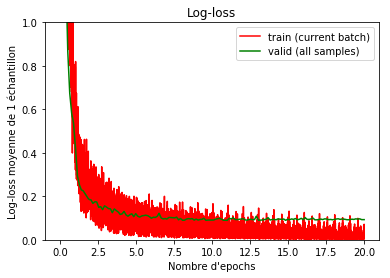

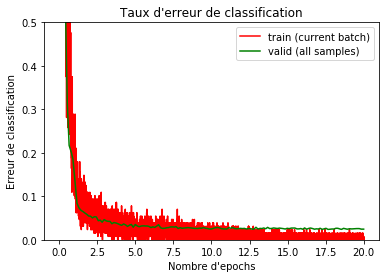

In [106]:
print("Classification rate for test set : {:.2f}%".format(nnet.score(test_set[0], test_set[1]) * 100))

epoch_array = np.arange(len(logloss_train)) / len(logloss_train) * N_EPOCH

plt.plot(epoch_array, logloss_train, "r", label='train (current batch)')
plt.plot(epoch_array, logloss_valid, "g", label='valid (all samples)')
plt.title("Log-loss")
plt.xlabel("Nombre d'epochs")
plt.ylabel("Log-loss moyenne de 1 échantillon")
plt.legend()
plt.ylim((0, 1))
plt.show()

plt.plot(epoch_array, error_train, "r", label='train (current batch)')
plt.plot(epoch_array, error_valid, "g", label='valid (all samples)')
plt.title("Taux d'erreur de classification")
plt.xlabel("Nombre d'epochs")
plt.ylabel("Erreur de classification")
plt.legend()
plt.ylim((0, 0.5))
plt.show()

## Optimisation des hyper-paramètres

On cherche à déterminer la meilleure configuration possible du réseau. Pour ceci, on entraîne différents réseaux avec des nombres de couches et de neurones différents.

Pour des raisons matérielles et de temps disponible, seules quelques configurations ont été testées. D'autres hyper-paramètres comme la valeur initiale de $\eta$ et son coefficient de diminution ont été optimisés lors du TP précédent et n'ont pas été re-testés.

Globalement, mis à part le cas d'un réseau sans couche cachée qui atteint des performances de l'ordre de 92%, les autres configurations ont des résultats similaires, de l'ordre de 97%.

Concernant le nombre d'epochs à utiliser pour l'entraînement, on remarque (voir figures précédentes) comme attendu que la log-loss et le taux d'erreur du jeu d'entraînement continue de diminuer. En revanche, pour le jeu de validation, on atteint un palier, voire même une légère remontée qui pourrait témoigner d'un sur-apprentissage.

In [80]:
TRAIN = True
N_EPOCH = 15
MINIBATCH_SIZE = 128
ETA_0 = 3
DECREASE_CONSTANT = 5e-4

n_neurons_config = [[],                             # 0 hidden layer
                    [30], [60], [100], [150],       # 1 hidden layer
                    [40, 20], [50, 30], [70, 40],   # 2 hidden layers
                    [70, 40, 20], [100, 70, 30]]    # 3 hidden layers

# train
if TRAIN:
    score_valid = []
    log_loss_valid = []
    error_rate_valid = []
    
    for config in n_neurons_config:
        print("Training for neurons config {}".format(config), end="")
        
        # train NNet on new config
        hidden_layers = [{'n_neurons': n_neurons, 'activation': 'sigmoid'} for n_neurons in config]
        nnet = NNet(784, 10, hidden_layers)
        _, _, logloss, error = nnet.train(train_set[0], train_set[1], 
                                          valid_set = valid_set, 
                                          n_epoch = N_EPOCH, 
                                          minibatch_size = MINIBATCH_SIZE, 
                                          eta_0 = ETA_0, 
                                          eta_decrease_factor = DECREASE_CONSTANT,
                                          verbose=False)
        # save curves and print score
        log_loss_valid.append(logloss)
        error_rate_valid.append(error)
        score_valid.append(nnet.score(valid_set[0], valid_set[1]))
        print(" : score = {:.3f}%".format(100 * score_valid[-1]))

Training for neurons config [] : score = 92.570%
Training for neurons config [30] : score = 96.580%
Training for neurons config [60] : score = 96.640%
Training for neurons config [100] : score = 96.720%
Training for neurons config [150] : score = 96.670%
Training for neurons config [40, 20] : score = 96.710%
Training for neurons config [50, 30] : score = 96.980%
Training for neurons config [70, 40] : score = 97.220%
Training for neurons config [70, 40, 20] : score = 97.150%
Training for neurons config [100, 70, 30] : score = 97.280%


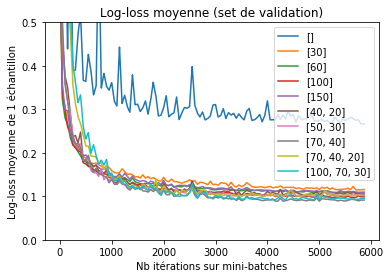

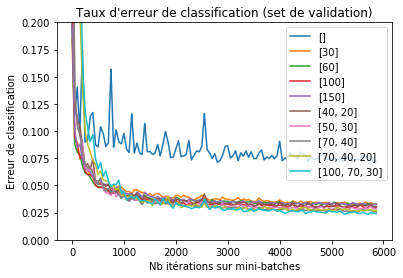

In [81]:
# display results
for i in range(len(n_neurons_config)):
    plt.plot(log_loss_valid[i], label="{}".format(n_neurons_config[i]))
plt.title("Log-loss moyenne (set de validation)")
plt.xlabel("Nb itérations sur mini-batches")
plt.ylabel("Log-loss moyenne de 1 échantillon")
plt.legend()
plt.ylim((0, 0.5))
plt.show()

for i in range(len(n_neurons_config)):
    plt.plot(error_rate_valid[i], label="{}".format(n_neurons_config[i]))
plt.title("Taux d'erreur de classification (set de validation)")
plt.xlabel("Nb itérations sur mini-batches")
plt.ylabel("Erreur de classification")
plt.legend()
plt.ylim((0, 0.2))
plt.show()

## Vérification du gradient

Afin de vérifier le calcul du gradient dans le réseau par *backward propagation*, on peut le comparer à celui obtenu par différences finies à l'aide de la formule

$$
\frac{\partial L(\mathbf{w})}{\partial w_{i}} \approx
\frac{L(\mathbf{w} + \epsilon \mathbf{e}_{i}) -L(\mathbf{w} - \epsilon
\mathbf{e}_{i})   }{2 \epsilon},
$$

où $L$ est la log-loss, $w$ les poids d'une couche et $\epsilon$ une faible variation.

In [94]:
from NNet import NNet

# load data
X = train_set[0]
y = train_set[1]
X_valid = valid_set[0]
y_valid = valid_set[1]

# neural network init
hidden_layers = [{'n_neurons': 70, 'activation': 'sigmoid'},
                 {'n_neurons': 30, 'activation': 'sigmoid'}]
nn = NNet(784, 10, hidden_layers)

In [95]:
def check_gradient(nnet, X, y, layer=0, eps=1e-5):
    """
    Check gradient computation by finite elements differences.
    """
    assert (0 <= layer <= nnet.n_hidden_layers + 1), "invalid 'layer' number"
        
    # computation of gradient by forward/backward propagation
    inputs, pre_activations, outputs, _ = nnet.forward(X)
    grad_weights_layers, grad_biases_layers = nnet.backward(inputs, pre_activations, outputs, y)
    grad_w = grad_weights_layers[layer]
    grad_b = grad_weights_layers[layer]
    sum_grad_w = np.sum(grad_w)

    # computation of gradient by finite elements approximation
    w_size = nnet.weights[layer].shape
    grad_w_approx = np.zeros(w_size)
    # loop on all W_ij
    for i in range(w_size[0]):
        for j in range(w_size[1]):
            w_eps = np.zeros(grad_w.shape)
            w_eps[i, j] = eps
            # compute L(W + eps)
            nnet.weights[layer] += w_eps
            logloss_plus = nnet.score(X, y, metric="logloss")
            # compute L(W - eps)
            nnet.weights[layer] -= 2*w_eps
            logloss_minus = nnet.score(X, y, metric="logloss")
            
            grad_w_approx[i, j] = (logloss_plus - logloss_minus) / (2 * eps)    
    sum_grad_w_approx = np.sum(grad_w_approx)
    
    # display results
    print("Sum of gradient w.r.t to W of layer {} :  backprop = {:.6f}    finiteelem = {:.6f}".format(layer, sum_grad_w, sum_grad_w_approx))
    mean_grad_error = np.mean(np.abs(grad_w - grad_w_approx)) / np.mean(np.abs(grad_w))
    print("Mean computation error of gradient w.r.t W between 2 methods : {:.4f}%".format(mean_grad_error * 100))
    
    return grad_w, grad_w_approx

In [96]:
grad_w, grad_w_approx = check_gradient(nn, X_valid[:5], y_valid[:5], layer=1)

Sum of gradient w.r.t to W of layer 1 :  backprop = -2.421580    finiteelem = -2.421446
Mean computation error of gradient w.r.t W between 2 methods : 0.0050%


L'erreur de calcul est donc bien négligeable : le calcul du gradient par propagation inverse est donc correct.